# Notebook Imports

In [188]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk .stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

from sklearn.model_selection import train_test_split

%matplotlib inline

# Constants

In [234]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'SpamData/01_Processing/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'SpamData/01_Processing/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'SpamData/01_Processing/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'SpamData/01_Processing/wordcloud_resources/OpenSansCondensed-Bold.ttf'

# Reading Files

In [211]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>


In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True
        
stream.close()

email_body = '\n'.join(lines)
print(email_body)

# print(lines)



Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generate_squares(N):
    for my_num in range(N):
        yield my_num ** 2

In [7]:
for i in generate_squares(5):
    print(i, end=' -> ')

0 -> 1 -> 4 -> 9 -> 16 -> 

# Email Body Extraction

In [8]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')
            
            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)

            yield file_name, email_body

In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
# Assuming df_from_directory returns a DataFrame
spam_emails_1 = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails_2 = df_from_directory(SPAM_2_PATH, SPAM_CAT)

# Using concat to concatenate the DataFrames
spam_emails = pd.concat([spam_emails_1, spam_emails_2])
# append version has been removed in newer versions of pandas

In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails_1 = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails_2 = df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT)
ham_emails = pd.concat([ham_emails_1, ham_emails_2])

In [13]:
ham_emails.shape

(3901, 2)

In [14]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is:', data.shape)
data.head()
data.tail()

Shape of entire dataframe is: (5799, 2)


MESSAGE  \
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...   
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...   
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...   

                                        CATEGORY  
01396.61983fbe6ec43f55fd44e30fce24ffa6         0  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0  
01398.169b51731fe569f42169ae8f948ec676         0  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0  
01400.f897f0931e461e7b2e964d28e927c35e         0

# Data Cleaning - checking for missing values

In [15]:
# check if any msg bodies are null
# data.MESSAGE.isnull().any()
data.MESSAGE.isnull().values.any()

False

In [16]:
my_var = None # null like
type(my_var)

NoneType

In [17]:
# check if there are empty emails (string length = 0)
(data.MESSAGE.str.len() == 0).any()

True

In [18]:
(data.MESSAGE.str.len() == 0).sum()

3

In [19]:
data.MESSAGE.isnull().sum()

0

## Locate Empty emails

In [20]:
type((data.MESSAGE.str.len() == 0))

pandas.core.series.Series

In [21]:
data[(data.MESSAGE.str.len() == 0)].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

# Remove system file entries from Dataframe

In [22]:
data.drop(['cmds'], inplace=True)
# this can be used instead of 
# data = data.drop(['cmds'])

In [23]:
data

MESSAGE  \
00001.7848dde101aa985090474a91ec93fcf0  <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...   
00002.d94f1b97e48ed3b553b3508d116e6a09  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00003.2ee33bc6eacdb11f38d052c44819ba6c  1) Fight The Risk of Cancer!\n\nhttp://www.adc...   
00004.eac8de8d759b7e74154f142194282724  ##############################################...   
00005.57696a39d7d84318ce497886896bf90d  I thought you might like these:\n\n1) Slim Dow...   
...                                                                                   ...   
01396.61983fbe6ec43f55fd44e30fce24ffa6  http://news.bbc.co.uk/1/hi/england/2515127.stm...   
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  > >-- be careful when using this one.) Also, t...   
01398.169b51731fe569f42169ae8f948ec676  >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...   
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  So then, "Mark Hammond" <mhammond@skippinet.co...   
01400.f897f0931e461e7b2e964d28e927c35e  Hi there,\n\n\n\nNow this is probably of no us...   

                                        CATEGORY  
00001.7848dde101aa985090474a91ec93fcf0         1  
00002.d94f1b97e48ed3b553b3508d116e6a09         1  
00003.2ee33bc6eacdb11f38d052c44819ba6c         1  
00004.eac8de8d759b7e74154f142194282724         1  
00005.57696a39d7d84318ce497886896bf90d         1  
...                                          ...  
01396.61983fbe6ec43f55fd44e30fce24ffa6         0  
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7         0  
01398.169b51731fe569f42169ae8f948ec676         0  
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896         0  
01400.f897f0931e461e7b2e964d28e927c35e         0  

[5796 rows x 2 columns]

# Add document IDs to track email in dataset

In [24]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [25]:
data.DOC_ID


00001.7848dde101aa985090474a91ec93fcf0       0
00002.d94f1b97e48ed3b553b3508d116e6a09       1
00003.2ee33bc6eacdb11f38d052c44819ba6c       2
00004.eac8de8d759b7e74154f142194282724       3
00005.57696a39d7d84318ce497886896bf90d       4
                                          ... 
01396.61983fbe6ec43f55fd44e30fce24ffa6    5791
01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7    5792
01398.169b51731fe569f42169ae8f948ec676    5793
01399.ca6b00b7b341bbde9a9ea3dd6a7bf896    5794
01400.f897f0931e461e7b2e964d28e927c35e    5795
Name: DOC_ID, Length: 5796, dtype: int64

In [26]:
data['FILE_NAME'] = data.index
data = data.set_index('DOC_ID')
data.head()


MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d

In [27]:
data.tail()

MESSAGE  CATEGORY  \
DOC_ID                                                                
5791    http://news.bbc.co.uk/1/hi/england/2515127.stm...         0   
5792    > >-- be careful when using this one.) Also, t...         0   
5793    >>>>> "SM" == Skip Montanaro <skip@pobox.com> ...         0   
5794    So then, "Mark Hammond" <mhammond@skippinet.co...         0   
5795    Hi there,\n\n\n\nNow this is probably of no us...         0   

                                     FILE_NAME  
DOC_ID                                          
5791    01396.61983fbe6ec43f55fd44e30fce24ffa6  
5792    01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7  
5793    01398.169b51731fe569f42169ae8f948ec676  
5794    01399.ca6b00b7b341bbde9a9ea3dd6a7bf896  
5795    01400.f897f0931e461e7b2e964d28e927c35e

# Save to File using Pandas

In [28]:
data.to_json(DATA_JSON_FILE)

# Number of spam messages visualized (Pie charts)

In [29]:
data.CATEGORY.value_counts()

CATEGORY
0    3900
1    1896
Name: count, dtype: int64

In [30]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

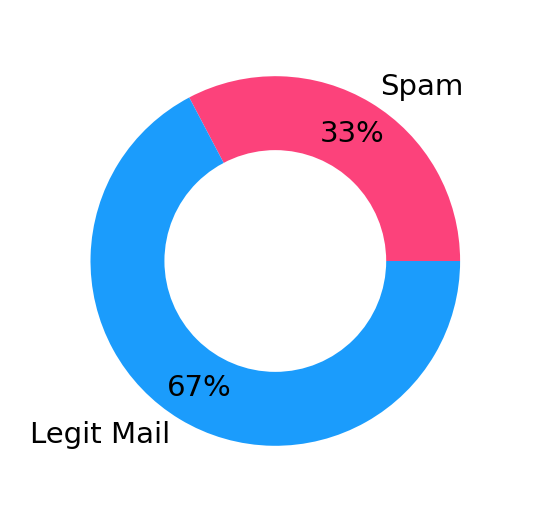

In [31]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colors = ['#FC427B', '#1B9CFC']

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 7}, startangle=0, autopct='%1.0f%%', 
        colors=custom_colors, pctdistance=0.8)

# drawign a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

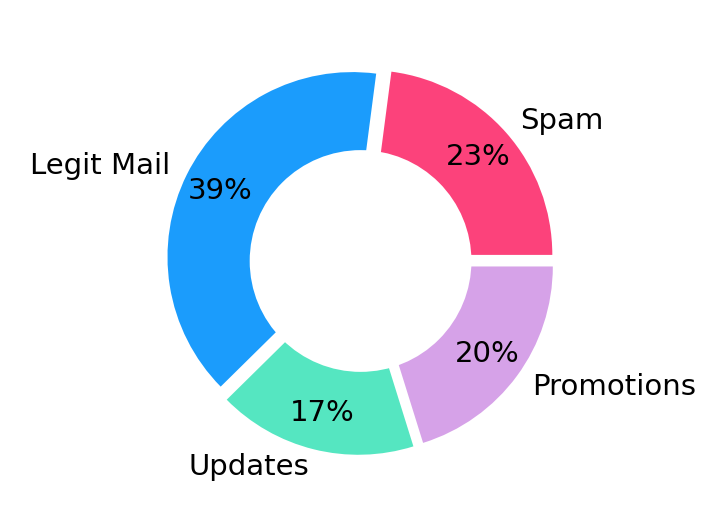

In [32]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colors = ['#FC427B', '#1B9CFC', '#55E6C1', '#D6A2E8']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=300)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 7}, startangle=0, autopct='%1.0f%%', 
        colors=custom_colors, pctdistance=0.8, explode=offset)

# drawign a circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

## Text Pre-Processing

In [33]:
# convert to lower case

msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizers & Stopwords)

In [34]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BANGLADESH\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BANGLADESH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [76]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\BANGLADESH\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     C:\Users\BANGLADESH\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

### Tokenizing

In [36]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

### Removing Stopwords

In [37]:
# ex: the, on, which, are, etc... words which are important for grammer but do not convey any meaning on its own
stop_words = set(stopwords.words('english'))

In [38]:
type(stop_words)

set

In [39]:
if 'hello' in stop_words: print('Found it!')
if 'hello' not in stop_words: print('Nope!')

Nope!


In [40]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)
        
filtered_words

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']

## Word stems and stemming

In [41]:
# fishing, fished, fisher, fishlike => fish
# argue, argued, arguing, argues => argu (common prefix)

msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
       Nobody expects the Spanish Inquisition'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing Punctuation

In [42]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be?? \
       Nobody expects the Spanish Inquisition!'
words = word_tokenize(msg.lower())

stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)
        
print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'nobodi', 'expect', 'spanish', 'inquisit']


## Removing HTML tags from emails

In [43]:
soup = BeautifulSoup(data.at[0, 'MESSAGE'], 'html.parser')
print(soup.prettify())

<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">
<html>
 <head>
  <meta charset="utf-8" content='3D"text/html;' http-equiv="3DContent-T=" ype=""/>
  <meta 5.00.2314.1000"="" content='3D"MSHTML' name="3DGENERATOR"/>
 </head>
 <body>
  <!-- Inserted by Calypso -->
  <table black;="" border="3D0" cellpadding="3D0" cellspacing="3D2" display:="" id="3D_CalyPrintHeader_" none"="" r="ules=3Dnone" style='3D"COLOR:' width='3D"100%"'>
   <tbody>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
    <tr>
     <td colspan="3D3">
      <hr color="3Dblack" noshade="" size="3D1"/>
     </td>
    </tr>
   </tbody>
  </table>
  <!-- End Calypso -->
  <!-- Inserted by Calypso=

 -->
  <font color="3D#000000" face="3DVERDANA,ARIAL,HELVETICA" size="3D-2">
   <br/>
  </font>
  &lt;=

/TR&gt;
  <!-- End Calypso -->
  <font bold"="" color="3D#ff0000" face='3D"Copperplate' gothic="" ptsize='3D"10"' size="3D5">
   <center>
    Save up to 70% o

In [44]:
soup.get_text()

"\n\n\n\n\n\n\n\n\n\n\n\n\n\n<=\n\n/TR>\nSave up to 70% on Life Insurance.\nWhy Spend More Than You Have To?\n\n\nLife Quote Savings\n\n\n\n\n\n\n\n\n\n\n\nEnsurin=\n\ng your \n\n      family's financial security is very important. Life Quote Savings ma=\n\nkes \n\n      buying life insurance simple and affordable. We Provide FREE Access =\n\nto The \n\n      Very Best Companies and The Lowest Rates.\n\n\n\n\n\nLife Quote Savings is FAST, EAS=\n\nY and \n\n            SAVES you money! Let us help you get started with the best val=\n\nues in \n\n            the country on new coverage. You can SAVE hundreds or even tho=\n\nusands \n\n            of dollars by requesting a FREE quote from Lifequote Savings. =\n\nOur \n\n            service will take you less than 5 minutes to complete. Shop an=\n\nd \n\n            compare. SAVE up to 70% on all types of Life insurance! \n\n\n\n\nClick Here For Your=\n\n \n\n            Free Quote!\n\nProtecting your family is the best investment you'll 

## Function for email processing

In [45]:
def clean_message(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    
    words = word_tokenize(message.lower())
    # splits up individual words and converts to lower case
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            # removes stopwords and punctuations
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [46]:
clean_message(email_body)

['dear',
 'mr',
 'still',
 'good',
 'tide',
 'staff',
 'festiv',
 'season',
 'ahead',
 'christma',
 'crux',
 'fulli',
 'qualifi',
 'santa',
 'clau',
 'wonder',
 'whether',
 'might',
 'consid',
 'run',
 'santa',
 'grotto',
 'store',
 'wait',
 'probabl',
 'think',
 'make',
 'special',
 'well',
 'first',
 'made',
 'sever',
 'chang',
 'characteris',
 'father',
 'christma',
 'rather',
 'greet',
 'children',
 'shout',
 'ho',
 'ho',
 'ho',
 'prefer',
 'whisper',
 'phrase',
 'depend',
 'unfathom',
 'cruel',
 'world',
 'live',
 'addit',
 'gift',
 'rang',
 'felt',
 'hoop',
 'holder',
 'note',
 'also',
 'enclos',
 'sketch',
 'radic',
 'redesign',
 'santa',
 'outfit',
 'renam',
 'charact',
 'lord',
 'buckl',
 'would',
 'interest',
 'employ',
 'promis',
 'never',
 'let',
 'look',
 'forward',
 'hear',
 'best',
 'wish',
 'robin',
 'cooper',
 'excerpt',
 'book',
 'timewast',
 'letter',
 'robin',
 'cooper']

In [47]:
def clean_message_no_html(message, stemmer=PorterStemmer(), 
                  stop_words=set(stopwords.words('english'))):
    
    # removes html
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    words = word_tokenize(cleaned_text.lower())
    # splits up individual words and converts to lower case
    
    filtered_words = []
    
    for word in words:
        if word not in stop_words and word.isalpha():
            # removes stopwords and punctuations
            filtered_words.append(stemmer.stem(word))
    
    return filtered_words

In [48]:
clean_message_no_html(data.at[0, 'MESSAGE'])

['save',
 'life',
 'insur',
 'spend',
 'life',
 'quot',
 'save',
 'g',
 'famili',
 'financi',
 'secur',
 'import',
 'life',
 'quot',
 'save',
 'ke',
 'buy',
 'life',
 'insur',
 'simpl',
 'afford',
 'provid',
 'free',
 'access',
 'best',
 'compani',
 'lowest',
 'rate',
 'life',
 'quot',
 'save',
 'fast',
 'save',
 'money',
 'let',
 'us',
 'help',
 'get',
 'start',
 'best',
 'ue',
 'countri',
 'new',
 'coverag',
 'save',
 'hundr',
 'even',
 'usand',
 'dollar',
 'request',
 'free',
 'quot',
 'lifequot',
 'save',
 'servic',
 'take',
 'less',
 'minut',
 'complet',
 'shop',
 'compar',
 'save',
 'type',
 'life',
 'insur',
 'click',
 'free',
 'quot',
 'protect',
 'famili',
 'best',
 'invest',
 'r',
 'make',
 'receipt',
 'email',
 'error',
 'wish',
 'remov',
 'list',
 'pleas',
 'click',
 'type',
 'remov',
 'resid',
 'state',
 'prohibit',
 'solicit',
 'ce',
 'pleas',
 'disregard',
 'email']

# Apply Cleaning and Tokenization to all messages

## Slicing DataFrames and Series & creating subsets

In [49]:
data.iat[2, 0]
# row 2, column 0

"1) Fight The Risk of Cancer!\n\nhttp://www.adclick.ws/p.cfm?o=315&s=pk007\n\n\n\n2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days\n\nhttp://www.adclick.ws/p.cfm?o=249&s=pk007\n\n\n\n3) Get the Child Support You Deserve - Free Legal Advice\n\nhttp://www.adclick.ws/p.cfm?o=245&s=pk002\n\n\n\n4) Join the Web's Fastest Growing Singles Community\n\nhttp://www.adclick.ws/p.cfm?o=259&s=pk007\n\n\n\n5) Start Your Private Photo Album Online!\n\nhttp://www.adclick.ws/p.cfm?o=283&s=pk007\n\n\n\nHave a Wonderful Day,\n\nOffer Manager\n\nPrizeMama\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nIf you wish to leave this list please use the link below.\n\nhttp://www.qves.com/trim/?zzzz@spamassassin.taint.org%7C17%7C308417\n\n\n"

In [50]:
data.iloc[5:11]

MESSAGE  CATEGORY  \
DOC_ID                                                                
5       A POWERHOUSE GIFTING PROGRAM You Don't Want To...         1   
6       Help wanted.  We are a 14 year old fortune 500...         1   
7       <html>\n\n<head>\n\n<title>ReliaQuote - Save U...         1   
8       TIRED OF THE BULL OUT THERE?\n\nWant To Stop L...         1   
9       Dear ricardo1 ,\n\n\n\n<html>\n\n<body>\n\n<ce...         1   
10      Cellular Phone Accessories All At Below Wholes...         1   

                                     FILE_NAME  
DOC_ID                                          
5       00006.5ab5620d3d7c6c0db76234556a16f6c1  
6       00007.d8521faf753ff9ee989122f6816f87d7  
7       00008.dfd941deb10f5eed78b1594b131c9266  
8       00009.027bf6e0b0c4ab34db3ce0ea4bf2edab  
9       00010.445affef4c70feec58f9198cfbc22997  
10      00011.61816b9ad167657773a427d890d0468e

In [51]:
first_emails = data.MESSAGE.iloc[0:3]

nested_list = first_emails.apply(clean_message)


In [52]:
# flat_list = []
# for sublist in nested_list:
#     for item in sublist:
#         flat_list.append(item)


flat_list = [item for sublist in nested_list for item in sublist]


In [53]:
flat_list
len(flat_list)

321

In [54]:
%%time

# use apply() on all the messages in dataframe
nested_list = data.MESSAGE.apply(clean_message_no_html)

C:\Users\BANGLADESH\AppData\Local\Temp\ipykernel_13444\2513532985.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\BANGLADESH\AppData\Local\Temp\ipykernel_13444\2513532985.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


CPU times: total: 44.1 s
Wall time: 44.9 s


In [55]:
nested_list.head()

DOC_ID
0    [save, life, insur, spend, life, quot, save, g...
1    [fight, risk, cancer, http, slim, guarante, lo...
2    [fight, risk, cancer, http, slim, guarante, lo...
3    [adult, club, offer, free, membership, instant...
4    [thought, might, like, slim, guarante, lose, l...
Name: MESSAGE, dtype: object

In [56]:
nested_list.tail()

DOC_ID
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, dtype: object

## Using logic to slice dataframes

In [57]:
data[data.CATEGORY == 1]

MESSAGE  CATEGORY  \
DOC_ID                                                                
0       <!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Tr...         1   
1       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
2       1) Fight The Risk of Cancer!\n\nhttp://www.adc...         1   
3       ##############################################...         1   
4       I thought you might like these:\n\n1) Slim Dow...         1   
...                                                   ...       ...   
1891    <html>\n\n<head>\n\n<meta http-equiv="content-...         1   
1892    This is a multi-part message in MIME format.\n...         1   
1893    Dear Subscriber,\n\n\n\nIf I could show you a ...         1   
1894    ****Mid-Summer Customer Appreciation SALE!****...         1   
1895    ATTN:SIR/MADAN      \n\n\n\n                  ...         1   

                                     FILE_NAME  
DOC_ID                                          
0       00001.7848dde101aa985090474a91ec93fcf0  
1       00002.d94f1b97e48ed3b553b3508d116e6a09  
2       00003.2ee33bc6eacdb11f38d052c44819ba6c  
3       00004.eac8de8d759b7e74154f142194282724  
4       00005.57696a39d7d84318ce497886896bf90d  
...                                        ...  
1891    01396.e80a10644810bc2ae3c1b58c5fd38dfa  
1892    01397.f75f0dd0dd923faefa3e9cc5ecb8c906  
1893    01398.8ca7045aae4184d56e8509dc5ad6d979  
1894    01399.2319643317e2c5193d574e40a71809c2  
1895    01400.b444b69845db2fa0a4693ca04e6ac5c5  

[1896 rows x 3 columns]

In [58]:
doc_ids_spam = data[data.CATEGORY == 1].index
doc_ids_ham = data[data.CATEGORY == 0].index

In [59]:
doc_ids_ham

Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
       ...
       5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
      dtype='int64', name='DOC_ID', length=3900)

In [60]:
type(doc_ids_spam)

pandas.core.indexes.base.Index

In [61]:
type(nested_list)

pandas.core.series.Series

In [62]:
nested_list_ham = nested_list.loc[doc_ids_ham]
nested_list_spam = nested_list.loc[doc_ids_spam]

In [63]:
nested_list_spam

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
1891    [want, boss, train, home, studi, thousand, peo...
1892    [messag, mime, format, prefer, doctor, order, ...
1893    [dear, subscrib, could, show, way, get, visito...
1894    [custom, appreci, sale, express, appreci, loya...
1895    [attn, strictli, confidenti, pleas, introduc, ...
Name: MESSAGE, Length: 1896, dtype: object

In [64]:
flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
normal_words = pd.Series(flat_list_ham).value_counts()
# value.counts() => total nums of unique words
normal_words.shape[0]

20815

In [65]:
normal_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
Name: count, dtype: int64

In [66]:
flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()
# value.counts() => total nums of unique words
spam_words.shape[0]

13242

In [67]:
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
Name: count, dtype: int64

# Wordcloud

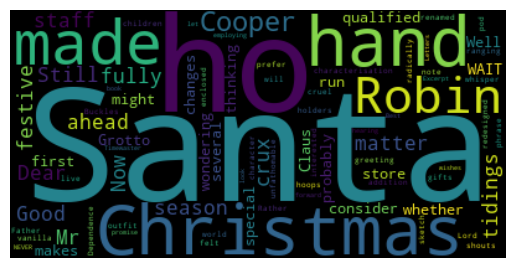

In [74]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [79]:
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [81]:
word_list = [''.join(word) for word in example_corpus]
word_list
novel_as_string = ' '.join(word_list)

In [82]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

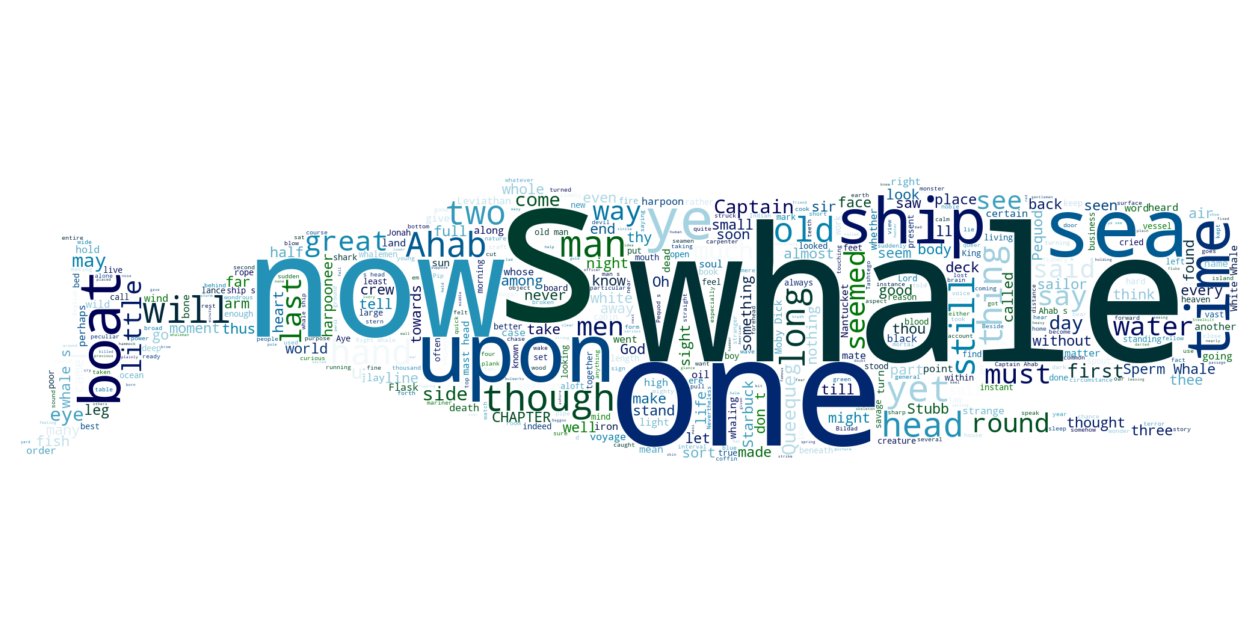

In [103]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts the image object into array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=500, colormap='ocean')
    
word_cloud.generate(novel_as_string)

plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [96]:
rgb_array.shape

(1024, 2048, 3)

In [102]:
rgb_array[194][340]

array([255, 255, 255], dtype=uint8)

In [111]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
novel_as_string = ' '.join(word_list)

In [112]:
novel_as_string

"[ The Tragedie of Hamlet by William Shakespeare 1599 ] Actus Primus . Scoena Prima . Enter Barnardo and Francisco two Centinels . Barnardo . Who ' s there ? Fran . Nay answer me : Stand & vnfold your selfe Bar . Long liue the King Fran . Barnardo ? Bar . He Fran . You come most carefully vpon your houre Bar . ' Tis now strook twelue , get thee to bed Francisco Fran . For this releefe much thankes : ' Tis bitter cold , And I am sicke at heart Barn . Haue you had quiet Guard ? Fran . Not a Mouse stirring Barn . Well , goodnight . If you do meet Horatio and Marcellus , the Riuals of my Watch , bid them make hast . Enter Horatio and Marcellus . Fran . I thinke I heare them . Stand : who ' s there ? Hor . Friends to this ground Mar . And Leige - men to the Dane Fran . Giue you good night Mar . O farwel honest Soldier , who hath relieu ' d you ? Fra . Barnardo ha ' s my place : giue you goodnight . Exit Fran . Mar . Holla Barnardo Bar . Say , what is Horatio there ? Hor . A peece of him Bar

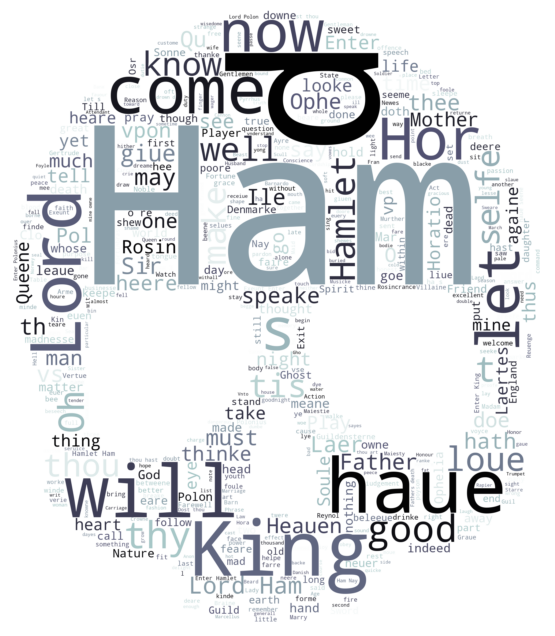

In [115]:
icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts the image object into array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=500, colormap='bone')
    
word_cloud.generate(novel_as_string)

plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [118]:
rgb_array[233][733]

array([1, 1, 1], dtype=uint8)

# WordCloud of ham and spam msgs

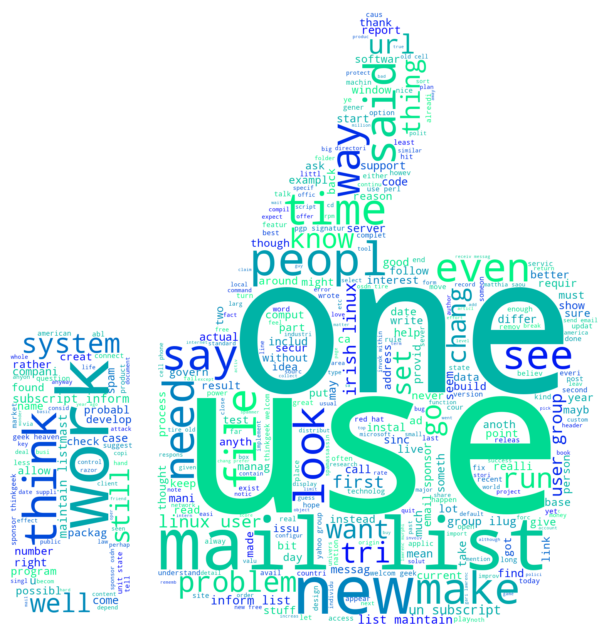

In [122]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts the image object into array

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='winter')
    
word_cloud.generate(ham_str)

plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

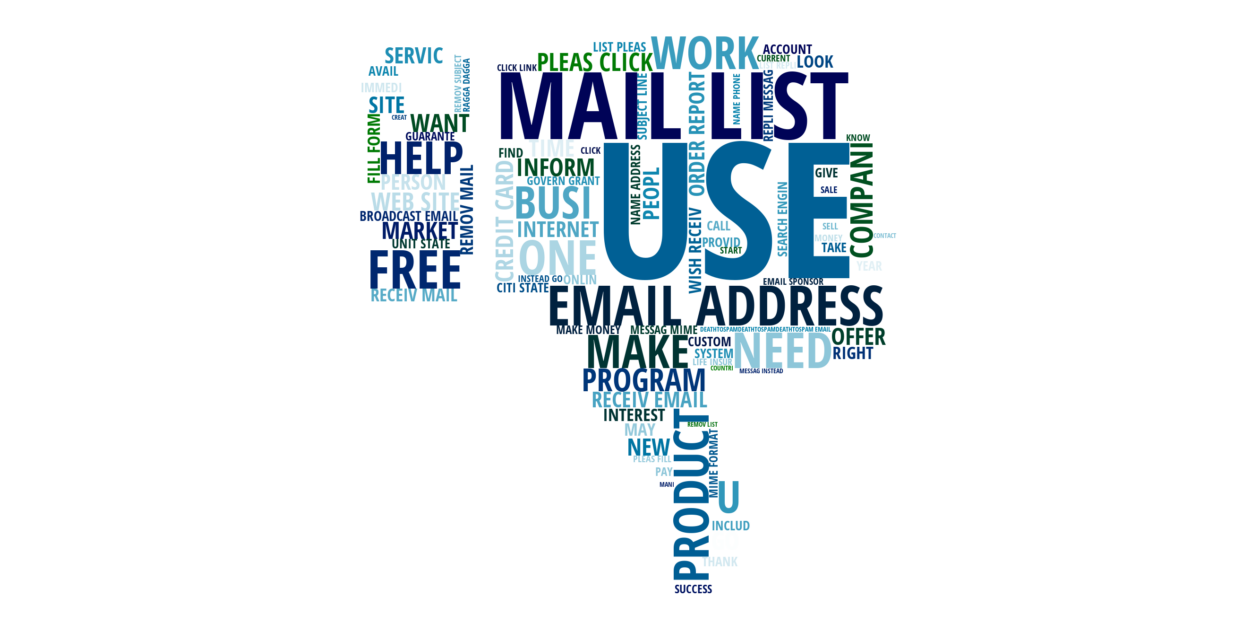

In [130]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask) # converts the image object into array

spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=2000, colormap='ocean', 
                       max_font_size=400, font_path=CUSTOM_FONT_FILE)
    
word_cloud.generate(spam_str.upper())

plt.figure(figsize=(16, 8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary and Dictionary

In [131]:
stemmed_nested_list = data.MESSAGE.apply(clean_message_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

C:\Users\BANGLADESH\AppData\Local\Temp\ipykernel_13444\2513532985.py:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')
C:\Users\BANGLADESH\AppData\Local\Temp\ipykernel_13444\2513532985.py:5: MarkupResemblesLocatorWarning: The input looks more like a URL than markup. You may want to use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  soup = BeautifulSoup(message, 'html.parser')


In [134]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
unique_words.head()

http     10660
use       5019
list      4851
email     4367
get       4200
Name: count, dtype: int64

In [138]:
frequent_words = unique_words[:VOCAB_SIZE]
frequent_words[:10]
# 10 most frequent words

http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
Name: count, dtype: int64

## Create Vocabulary dataframe with a word_id

In [149]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

VOCAB_WORD
WORD_ID           
0             http
1              use
2             list
3            email
4              get

# Save the vocbulary as a csv file

In [150]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

# Exercise: Cheking if word is a part of the Vocabulary

In [151]:
any(vocab.VOCAB_WORD == 'machine')
# inefficient

False

In [162]:
'science' in set(vocab.VOCAB_WORD)
# efficient

False

# find the email with the most number of words

In [169]:
clean_email_length = [len(sublist) for sublist in stemmed_nested_list]
print('Number of words in the longest email:', max(clean_email_length))
print('Email position in the list:', np.argmax(clean_email_length))

Number of words in the longest email: 7671
Email position in the list: 5775


In [170]:
stemmed_nested_list[5775]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [174]:
data.at[5775, 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & Sparse Matrix
### Creating a dataframe with one word per column

In [178]:
stemmed_nested_list

DOC_ID
0       [save, life, insur, spend, life, quot, save, g...
1       [fight, risk, cancer, http, slim, guarante, lo...
2       [fight, risk, cancer, http, slim, guarante, lo...
3       [adult, club, offer, free, membership, instant...
4       [thought, might, like, slim, guarante, lose, l...
                              ...                        
5791    [http, bizarr, collect, stuf, anim, could, fet...
5792    [care, use, one, also, realli, cute, thing, ja...
5793    [sm, skip, montanaro, write, jeremi, put, anot...
5794    [mark, hammond, like, given, zodb, sound, attr...
5795    [hi, probabl, use, whatsoev, also, problem, re...
Name: MESSAGE, Length: 5796, dtype: object

In [181]:
type(stemmed_nested_list.tolist())

list

In [182]:
stemmed_nested_list.tolist()

[['save',
  'life',
  'insur',
  'spend',
  'life',
  'quot',
  'save',
  'g',
  'famili',
  'financi',
  'secur',
  'import',
  'life',
  'quot',
  'save',
  'ke',
  'buy',
  'life',
  'insur',
  'simpl',
  'afford',
  'provid',
  'free',
  'access',
  'best',
  'compani',
  'lowest',
  'rate',
  'life',
  'quot',
  'save',
  'fast',
  'save',
  'money',
  'let',
  'us',
  'help',
  'get',
  'start',
  'best',
  'ue',
  'countri',
  'new',
  'coverag',
  'save',
  'hundr',
  'even',
  'usand',
  'dollar',
  'request',
  'free',
  'quot',
  'lifequot',
  'save',
  'servic',
  'take',
  'less',
  'minut',
  'complet',
  'shop',
  'compar',
  'save',
  'type',
  'life',
  'insur',
  'click',
  'free',
  'quot',
  'protect',
  'famili',
  'best',
  'invest',
  'r',
  'make',
  'receipt',
  'email',
  'error',
  'wish',
  'remov',
  'list',
  'pleas',
  'click',
  'type',
  'remov',
  'resid',
  'state',
  'prohibit',
  'solicit',
  'ce',
  'pleas',
  'disregard',
  'email'],
 ['fight',
  

In [183]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [187]:
word_columns_df.shape

(5796, 7671)

# Splitting Data into training and testing data set

In [189]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY, test_size=0.3, random_state=42)

In [192]:
print('Number of training samples', X_train.shape[0])
print('Fraction of the training set', X_train.shape[0] / word_columns_df.shape[0])

Number of training samples 4057
Fraction of the training set 0.6999654934437544


In [195]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

0       1      2          3            4      5        6     \
DOC_ID                                                                   
4844         ye    inde  agent  directori       verita     cd     unix   
4727    problem    come    tri     instal  harddissssk   like  alreadi   
5022     origin  messag   date        mon          aug   chad  norwood   
3504      inlin    folk  sever      major     internet  outag     morn   
3921        url    http   date       bath     chronicl   None     None   

                7      8        9     ...  7661  7662  7663  7664  7665  7666  \
DOC_ID                                ...                                       
4844    subdirectori   file     call  ...  None  None  None  None  None  None   
4727           mount   http    yahoo  ...  None  None  None  None  None  None   
5022            sven     cc  subject  ...  None  None  None  None  None  None   
3504          across  major   provid  ...  None  None  None  None  None  None   
3921            None   None     None  ...  None  None  None  None  None  None   

        7667  7668  7669  7670  
DOC_ID                          
4844    None  None  None  None  
4727    None  None  None  None  
5022    None  None  None  None  
3504    None  None  None  None  
3921    None  None  None  None  

[5 rows x 7671 columns]

In [196]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64


# Create sparse matrix for training data

In [205]:
word_index = pd.Index(vocab.VOCAB_WORD)
word_index.get_loc('thu')

393

In [207]:
word_index.get_loc('rodent')
# won't be added to the sparse matrix, because not in VOCAB_WORD

KeyError: 'rodent'

In [208]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train, y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id, 'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
        
    return pd.DataFrame(dict_list)

In [210]:
%%time

sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: total: 12min 18s
Wall time: 18min 37s


In [215]:
sparse_train_df[:5]

LABEL  DOC_ID  OCCURENCE  WORD_ID
0      0    4844          1      265
1      0    4844          1     1243
2      0    4844          1      502
3      0    4844          1      308
4      0    4844          1      254

In [216]:
sparse_train_df.shape

(429241, 4)

In [217]:
sparse_train_df.tail()

LABEL  DOC_ID  OCCURENCE  WORD_ID
429236      1     860          1       47
429237      1     860          1     1431
429238      1     860          1       26
429239      1     860          1       21
429240      1     860          1      126

# Combine occurence with pandas groupby() method

In [243]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      2       1              1
       3       1              2
       4       1              1
       7       1              3
       11      1              1

In [244]:
vocab.at[7, 'VOCAB_WORD']

'free'

In [222]:
data.MESSAGE[0]

'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 4.0 Transitional//EN">\n\n<HTML><HEAD>\n\n<META content=3D"text/html; charset=3Dwindows-1252" http-equiv=3DContent-T=\n\nype>\n\n<META content=3D"MSHTML 5.00.2314.1000" name=3DGENERATOR></HEAD>\n\n<BODY><!-- Inserted by Calypso -->\n\n<TABLE border=3D0 cellPadding=3D0 cellSpacing=3D2 id=3D_CalyPrintHeader_ r=\n\nules=3Dnone \n\nstyle=3D"COLOR: black; DISPLAY: none" width=3D"100%">\n\n  <TBODY>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TD></TR>\n\n  <TR>\n\n    <TD colSpan=3D3>\n\n      <HR color=3Dblack noShade SIZE=3D1>\n\n    </TD></TR></TBODY></TABLE><!-- End Calypso --><!-- Inserted by Calypso=\n\n --><FONT \n\ncolor=3D#000000 face=3DVERDANA,ARIAL,HELVETICA size=3D-2><BR></FONT></TD><=\n\n/TR></TABLE><!-- End Calypso --><FONT color=3D#ff0000 \n\nface=3D"Copperplate Gothic Bold" size=3D5 PTSIZE=3D"10">\n\n<CENTER>Save up to 70% on Life Insurance.</CENTER></FONT><FONT color=3D#ff=\n\n0000

In [255]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       0        2      1          1
1       0        3      1          2
2       0        4      1          1
3       0        7      1          3
4       0       11      1          1

In [224]:
train_grouped.tail()

DOC_ID  WORD_ID  LABEL  OCCURENCE
258355    5795     2035      0          2
258356    5795     2040      0          1
258357    5795     2272      0          1
258358    5795     2342      0          1
258359    5795     2370      0          1

In [233]:
vocab.at[2035, 'VOCAB_WORD']

'swap'

In [227]:
data.MESSAGE[5795]

"Hi there,\n\n\n\nNow this is probably of no use to you whatsoever, but...\n\n\n\nNot a deb-head, but I also have a problem regards NVidia. I've two machines,\n\npretty much the same hardware. \n\nathlon 1700XP's, both have NVidia cards, one Gforce3 Ti and a Gforce2MX,\n\nboth use the same driver module. \n\n\n\nBoth have same kernel version albeit it compiled for their particular\n\nhardware.\n\n\n\nOne works perfectly, the other fails to load. When I check with lsmod, I can\n\nsee the NVdriver is loaded, but not used ;--(\n\nThus when I startx, it bombs out. \n\n\n\nIU still have X with the default nv driver and crappy accelleration -->\n\n650fps with glxgears [should be over 2000fps]\n\nIts not a hardware issue with the cards as I swapped them over and get the\n\nsame symptoms. \n\n\n\nI reckon my mobo is cack, I've tried swapping slots around, reserving\n\nresources etc all to no avail. \n\nShould there be an interrupt for the nv card? I haven't checked the other\n\nbox yet.\n\n\n\

In [228]:
train_grouped.shape

(258360, 4)

# Save training data as .txt file

In [230]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [231]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

In [235]:
X_test.head()

0        1       2         3          4         5          6     \
DOC_ID                                                                        
4675    interest    alway  wonder     thing        bad    exampl       goto   
4220         url     http    date     final        gdc     europ     review   
2484     stephen  william  mailto  swilliam     weaken      food   transact   
2418          el      mon     sep  bitbitch      wrote     eugen       mani   
5110       music   school    joke  american  conductor  european  conductor   

             7         8             9     ...  7661  7662  7663  7664  7665  \
DOC_ID                                     ...                                 
4675      languag   support          goto  ...  None  None  None  None  None   
4220    confernec   session           ect  ...  None  None  None  None  None   
2484     argument      note  neighborhood  ...  None  None  None  None  None   
2418         homo    friend         lover  ...  None  None  None  None  None   
5110         talk  european     conductor  ...  None  None  None  None  None   

        7666  7667  7668  7669  7670  
DOC_ID                                
4675    None  None  None  None  None  
4220    None  None  None  None  None  
2484    None  None  None  None  None  
2418    None  None  None  None  None  
5110    None  None  None  None  None  

[5 rows x 7671 columns]

In [237]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [238]:
X_test.shape

(1739, 7671)

In [239]:
%%time

sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: total: 6min 12s
Wall time: 9min 35s


In [240]:
sparse_test_df.shape             

(203366, 4)

In [246]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

DOC_ID  WORD_ID  LABEL  OCCURENCE
0       8        2      1          1
1       8        3      1          4
2       8        4      1          2
3       8        5      1          1
4       8        6      1          2

In [247]:
test_grouped.shape

(117776, 4)

In [248]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-processing subtleties and checking your understanding

In [257]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [258]:
len(test_doc_ids)

1724

In [260]:
len(X_test)

1739

In [263]:
set(X_test.index) - test_doc_ids

{134, 179, 240, 274, 298, 339, 439, 471, 670, 734, 765, 945, 1544, 1670, 1700}

In [268]:
data.MESSAGE[134]

'------=_NextPart_000_00E8_85C13B1D.B7243B86\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+DQoNCjxib2R5IGJnY29sb3I9IiNGRkZGRkYiIHRleHQ9IiMwMDAw\n\nMDAiPiANCjxwIGFsaWduPSJjZW50ZXIiPjxhIGhyZWY9Imh0dHA6Ly93d3cu\n\nZGlyZWN0d2Vic3RvcmUuY29tL3RveXMvaW5kZXguaHRtbCI+PGltZyBzcmM9\n\nImh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL21waWMuanBnIiB3aWR0\n\naD0iNTAwIiBoZWlnaHQ9IjMzOSIgYm9yZGVyPSIwIj48L2E+PGJyPiANCjxm\n\nb250IHNpemU9IjMiIGZhY2U9IkFyaWFsLCBIZWx2ZXRpY2EsIHNhbnMtc2Vy\n\naWYiPjxhIGhyZWY9Imh0dHA6Ly93d3cuZGlyZWN0d2Vic3RvcmUuY29tL3Rv\n\neXMvaW5kZXguaHRtbCI+PGI+RU5URVIgDQpOT1cgaWYgeW91IGFyZSAxOCBh\n\nbmQgb3ZlcjwvYj48L2E+PC9mb250PjwvcD4gDQo8cCBhbGlnbj0iY2VudGVy\n\nIj48Zm9udCBmYWNlPSJBcmlhbCwgSGVsdmV0aWNhLCBzYW5zLXNlcmlmIiBz\n\naXplPSI0IiBjb2xvcj0iI0ZGMDAwMCI+PGI+U1BFQ0lBTCANCk9GRkVSPGJy\n\nPiANCjxmb250IHNpemU9IjUiPjMwIERheXMgPGk+RlJFRSBhY2Nlc3M8L2k+\n\nIDwvZm9udD48YnI+IA0KdG8gdGhlIGxhcmdlc3QgQWR1bHRzaXRlIG9uIHRo\n\nZSB3ZWIuPGJyPiANCjwvYj4gPG

In [273]:
data.loc[179]

MESSAGE      ------=_NextPart_000_00A5_78C83A6B.A1543A16\n\...
CATEGORY                                                     1
FILE_NAME               00180.13a95a2542a0fd01ff24303561cca949
Name: 179, dtype: object

In [278]:
clean_message_no_html(data.at[179, 'MESSAGE'])

[]